# 14.1 Panel Data Structure

**Chapter**: 14 - Panel Data and Fixed Effects  
**Section**: 1 - Understanding Panel Structure  
**Facure Source**: 14-Panel-Data-and-Fixed-Effects.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Controlling What You Cannot See](#11-controlling-what-you-cannot-see)
   - 1.2 [The Power of Repeated Observations](#12-the-power-of-repeated-observations)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Panel Data Notation](#21-panel-data-notation)
   - 2.2 [Fixed Effects Model Structure](#22-fixed-effects-model-structure)
   - 2.3 [Connection to Parallel Trends](#23-connection-to-parallel-trends)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [The Wage Panel Dataset](#31-the-wage-panel-dataset)
   - 3.2 [Exploring Panel Structure](#32-exploring-panel-structure)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

# Panel data library
from linearmodels.datasets import wage_panel

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Panel data and fixed effects are fundamental tools in applied causal inference. Understanding when fixed effects work—and what they can't solve—is essential for any senior data scientist working with observational data.

### 1.1 Controlling What You Cannot See

Methods like propensity score, linear regression, and matching rely on a critical assumption: **conditional unconfoundedness**.

$$
(Y_0, Y_1) \perp\!\!\!\perp T | X
$$

In words: all confounders are measured, allowing us to condition on them and make treatment "as good as random."

**The problem**: Some confounders cannot be measured.

**Facure's Example—Marriage Premium**:

- **Question**: Does marriage *cause* men to earn more?
- **Observation**: Married men earn more than single men
- **Potential confounders**:
  - Education (measurable)
  - Ability/intelligence (unmeasurable)
  - Physical attractiveness (unmeasurable)

If more attractive men are both more likely to marry AND earn more, beauty confounds the effect. **We cannot control for what we cannot measure.**

### 1.2 The Power of Repeated Observations

**Key insight**: By tracking the same individual over time, we implicitly control for anything that is *fixed* over time.

- Beauty is constant (over short periods)
- Intelligence is constant
- Baseline ambition is constant

Even if we can't measure these attributes, **we know they're the same for a given individual across time**.

$$
\text{Zooming into one person } \Rightarrow \text{ Time-invariant confounders hold fixed}
$$

★ Insight ─────────────────────────────────────
- Panel data lets us control for *unmeasured* confounders
- The only requirement: confounders must be fixed over time
- This is the key advantage over cross-sectional data
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Panel Data Notation

A **panel dataset** (or longitudinal data) contains repeated observations on the same units over time.

**Notation**:

| Symbol | Meaning |
|--------|--------|
| $Y_{it}$ | Outcome for unit $i$ at time $t$ |
| $X_{it}$ | Observed covariates (may vary over time) |
| $T_{it}$ | Treatment status (time-varying) |
| $\alpha_i$ | Unit-specific fixed effect (time-invariant) |
| $\lambda_t$ | Time-specific effect (common across units) |
| $i = 1, \ldots, N$ | Unit index |
| $t = 1, \ldots, T$ | Time period index |

**Panel dimensions**:
- **Balanced panel**: Every unit observed at every time point ($N \times T$ observations)
- **Unbalanced panel**: Some unit-time combinations missing

### 2.2 Fixed Effects Model Structure

The general fixed effects model:

$$
Y_{it} = \beta T_{it} + \gamma' X_{it} + \underbrace{\alpha_i}_{\text{unit FE}} + \underbrace{\lambda_t}_{\text{time FE}} + \epsilon_{it}
$$

where:
- $\beta$: Causal effect of treatment (our target)
- $\alpha_i$: Captures ALL time-invariant unit characteristics (measured or not)
- $\lambda_t$: Captures ALL time-specific shocks (common to all units)
- $\epsilon_{it}$: Idiosyncratic error

**What the unit fixed effect absorbs**:

$$
\alpha_i = f(\text{intelligence}_i, \text{beauty}_i, \text{baseline ability}_i, \ldots)
$$

Any time-invariant characteristic—measurable or not—is captured by $\alpha_i$.

### 2.3 Connection to Parallel Trends

Recall the DiD parallel trends assumption:

$$
E[Y_0(t) - Y_0(t-1) | T=1] = E[Y_0(t) - Y_0(t-1) | T=0]
$$

**Fixed effects relax this**. Under the FE model:

$$
E[\epsilon_{it} | \alpha_i, \lambda_t, T_{it}] = 0
$$

We require:
1. No time-varying confounders (beyond $\lambda_t$)
2. Treatment timing is uncorrelated with idiosyncratic shocks
3. Constant treatment effect across units

**Key distinction**:

| Aspect | DiD | Fixed Effects |
|--------|-----|---------------|
| Treatment structure | One-time, group-level | Time-varying, unit-level |
| Identification | Parallel trends | Strict exogeneity |
| Time periods | Pre/Post | Multiple |
| Units | Treated vs Control groups | Same units over time |

---

## 3. Numeric Demonstration

### 3.1 The Wage Panel Dataset

We use the classic wage panel from `linearmodels`—tracking 545 individuals over 8 years.

In [2]:
# Load the wage panel dataset
data = wage_panel.load()

print("=" * 60)
print("WAGE PANEL DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal observations: {len(data):,}")
print(f"Unique individuals: {data['nr'].nunique():,}")
print(f"Time periods: {sorted(data['year'].unique())}")
print(f"Years covered: {data['year'].min()} - {data['year'].max()}")
print(f"\nPanel structure: {data['nr'].nunique()} individuals × {data['year'].nunique()} years = {data['nr'].nunique() * data['year'].nunique():,} obs")

# Check if balanced
obs_per_person = data.groupby('nr').size()
print(f"\nBalanced panel: {obs_per_person.nunique() == 1 and obs_per_person.iloc[0] == data['year'].nunique()}")

WAGE PANEL DATASET OVERVIEW

Total observations: 4,360
Unique individuals: 545
Time periods: [np.int64(1980), np.int64(1981), np.int64(1982), np.int64(1983), np.int64(1984), np.int64(1985), np.int64(1986), np.int64(1987)]
Years covered: 1980 - 1987

Panel structure: 545 individuals × 8 years = 4,360 obs

Balanced panel: True


In [3]:
# Data dictionary
print("\nVARIABLE DICTIONARY:")
print("-" * 60)

variable_descriptions = {
    'nr': 'Individual identifier (entity)',
    'year': 'Time period (1980-1987)',
    'black': 'Race indicator (1 = Black)',
    'exper': 'Years of work experience',
    'hisp': 'Ethnicity indicator (1 = Hispanic)',
    'hours': 'Hours worked per year',
    'married': 'Marital status (1 = Married) — TREATMENT',
    'educ': 'Years of education',
    'union': 'Union membership (1 = Member)',
    'lwage': 'Log wages — OUTCOME',
    'expersq': 'Experience squared',
    'occupation': 'Occupation code'
}

for var, desc in variable_descriptions.items():
    print(f"  {var:12} : {desc}")


VARIABLE DICTIONARY:
------------------------------------------------------------
  nr           : Individual identifier (entity)
  year         : Time period (1980-1987)
  black        : Race indicator (1 = Black)
  exper        : Years of work experience
  hisp         : Ethnicity indicator (1 = Hispanic)
  hours        : Hours worked per year
  married      : Marital status (1 = Married) — TREATMENT
  educ         : Years of education
  union        : Union membership (1 = Member)
  lwage        : Log wages — OUTCOME
  expersq      : Experience squared
  occupation   : Occupation code


In [4]:
# Sample of the data
print("\nSAMPLE DATA (Individual #13 over time):")
print("=" * 60)
print(data[data['nr'] == 13][['nr', 'year', 'married', 'lwage', 'hours', 'union', 'educ']].to_string(index=False))


SAMPLE DATA (Individual #13 over time):
 nr  year  married   lwage  hours  union  educ
 13  1980        0  1.1975   2672      0    14
 13  1981        0  1.8531   2320      1    14
 13  1982        0  1.3445   2940      0    14
 13  1983        0  1.4332   2960      0    14
 13  1984        0  1.5681   3071      0    14
 13  1985        0  1.6999   2864      0    14
 13  1986        0 -0.7203   2994      0    14
 13  1987        0  1.6692   2640      0    14


### 3.2 Exploring Panel Structure

Understanding which variables are time-invariant vs time-varying is crucial for fixed effects.

In [5]:
# Identify time-invariant vs time-varying variables
within_variation = data.groupby('nr').std().sum()

print("WITHIN-UNIT VARIATION (Standard Deviation Summed Across Individuals):")
print("=" * 70)
print("\nVariables with ZERO within-unit variation (TIME-INVARIANT):")
print("-" * 70)
for var in within_variation.index:
    if within_variation[var] == 0:
        print(f"  {var:12} : Cannot be estimated in FE model (absorbed by α_i)")

print("\nVariables with POSITIVE within-unit variation (TIME-VARYING):")
print("-" * 70)
for var in within_variation.index:
    if within_variation[var] > 0:
        print(f"  {var:12} : Within-unit SD = {within_variation[var]:.2f}")

WITHIN-UNIT VARIATION (Standard Deviation Summed Across Individuals):

Variables with ZERO within-unit variation (TIME-INVARIANT):
----------------------------------------------------------------------
  black        : Cannot be estimated in FE model (absorbed by α_i)
  hisp         : Cannot be estimated in FE model (absorbed by α_i)
  educ         : Cannot be estimated in FE model (absorbed by α_i)

Variables with POSITIVE within-unit variation (TIME-VARYING):
----------------------------------------------------------------------
  year         : Within-unit SD = 1334.97
  exper        : Within-unit SD = 1334.97
  hours        : Within-unit SD = 203098.22
  married      : Within-unit SD = 140.37
  union        : Within-unit SD = 106.51
  lwage        : Within-unit SD = 173.93
  expersq      : Within-unit SD = 17608.24
  occupation   : Within-unit SD = 739.22


In [6]:
# Visualize marriage transitions
marriage_changes = data.groupby('nr')['married'].apply(lambda x: x.diff().sum())

print("\nMARRIAGE TRANSITIONS IN PANEL:")
print("=" * 50)
print(f"Individuals who never married:    {(marriage_changes == 0).sum()}")
print(f"Individuals who got married once: {(marriage_changes == 1).sum()}")
print(f"Individuals who got married 2+ :  {(marriage_changes >= 2).sum()}")
print(f"Individuals who got divorced:     {(marriage_changes < 0).sum()}")

# Total variation in treatment
print(f"\nTotal marriage events: {int(marriage_changes.abs().sum())}")
print(f"Proportion with any change: {(marriage_changes != 0).mean():.1%}")


MARRIAGE TRANSITIONS IN PANEL:
Individuals who never married:    277
Individuals who got married once: 251
Individuals who got married 2+ :  0
Individuals who got divorced:     17

Total marriage events: 268
Proportion with any change: 49.2%


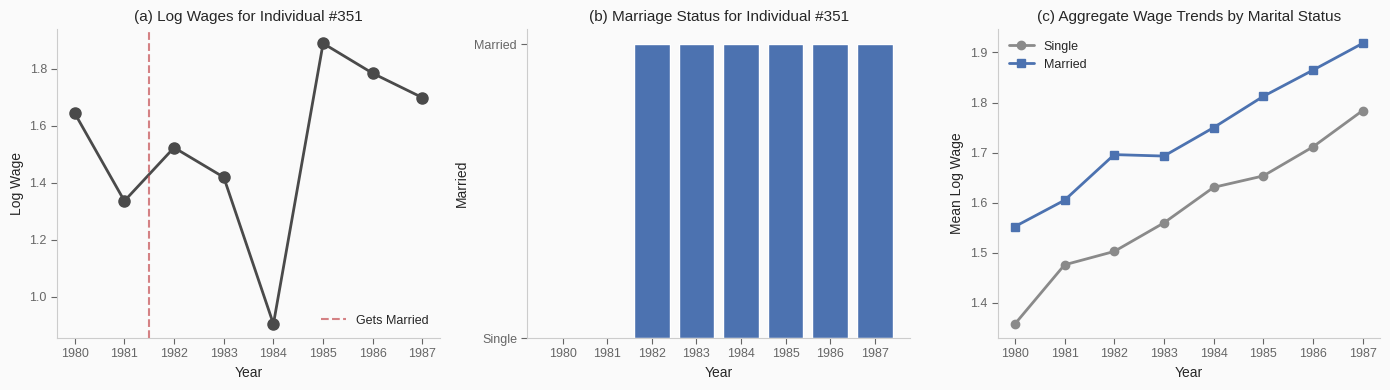

In [7]:
# Visualize one individual's trajectory
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Select an individual who gets married during the panel
changers = marriage_changes[marriage_changes > 0].index
example_id = changers[10] if len(changers) > 10 else changers[0]
person = data[data['nr'] == example_id].sort_values('year')

# Panel 1: Wages over time
ax = axes[0]
ax.plot(person['year'], person['lwage'], 'o-', color=TUFTE_PALETTE['primary'], linewidth=2, markersize=8)

# Mark marriage transition
marriage_year = person[person['married'] == 1]['year'].min()
ax.axvline(marriage_year - 0.5, color=TUFTE_PALETTE['effect'], linestyle='--', alpha=0.7, label='Gets Married')
ax.set_xlabel('Year')
ax.set_ylabel('Log Wage')
ax.set_title(f'(a) Log Wages for Individual #{example_id}')
ax.legend(frameon=False)

# Panel 2: Marriage status
ax = axes[1]
colors = [TUFTE_PALETTE['control'] if m == 0 else TUFTE_PALETTE['treatment'] for m in person['married']]
ax.bar(person['year'], person['married'], color=colors, edgecolor='white')
ax.set_xlabel('Year')
ax.set_ylabel('Married')
ax.set_title(f'(b) Marriage Status for Individual #{example_id}')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Single', 'Married'])

# Panel 3: Aggregate wage trends by marital status
ax = axes[2]
agg_wages = data.groupby(['year', 'married'])['lwage'].mean().unstack()
ax.plot(agg_wages.index, agg_wages[0], 'o-', color=TUFTE_PALETTE['control'], label='Single', linewidth=2, markersize=6)
ax.plot(agg_wages.index, agg_wages[1], 's-', color=TUFTE_PALETTE['treatment'], label='Married', linewidth=2, markersize=6)
ax.set_xlabel('Year')
ax.set_ylabel('Mean Log Wage')
ax.set_title('(c) Aggregate Wage Trends by Marital Status')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

**Interpretation**:

1. **Panel (a)**: Individual trajectories show within-person wage changes
2. **Panel (b)**: Marriage is a time-varying treatment (turns "on" mid-panel)
3. **Panel (c)**: Cross-sectionally, married men earn more—but is this causal?

The fixed effects model will identify the marriage effect using *within-person variation*—comparing the same individual before and after marriage.

★ Insight ─────────────────────────────────────
- Fixed effects uses *within-unit* variation only
- Individuals who never change treatment status contribute no information
- The "effect" comes from people who transition into (or out of) treatment
─────────────────────────────────────────────────

In [8]:
# Summary statistics: between vs within variation
print("\nVARIANCE DECOMPOSITION:")
print("=" * 70)
print("\nVariable          Between-Unit    Within-Unit    Total       % Within")
print("-" * 70)

for var in ['lwage', 'married', 'hours', 'union']:
    # Total variance
    total_var = data[var].var()
    
    # Between variance (variance of unit means)
    unit_means = data.groupby('nr')[var].mean()
    between_var = unit_means.var()
    
    # Within variance (mean of within-unit variances)
    within_var = data.groupby('nr')[var].var().mean()
    
    pct_within = 100 * within_var / total_var if total_var > 0 else 0
    
    print(f"{var:16}  {between_var:12.4f}  {within_var:12.4f}  {total_var:10.4f}  {pct_within:8.1f}%")

print("\n" + "-" * 70)
print("Note: FE models use ONLY within-unit variation for identification")


VARIANCE DECOMPOSITION:

Variable          Between-Unit    Within-Unit    Total       % Within
----------------------------------------------------------------------
lwage                   0.1527        0.1499      0.2837      52.9%
married                 0.1418        0.1197      0.2463      48.6%
hours              145758.3054   200217.7169  320754.9289      62.4%
union                   0.1085        0.0870      0.1845      47.2%

----------------------------------------------------------------------
Note: FE models use ONLY within-unit variation for identification


---

## 4. Implementation

The production panel data estimators in `causal_inference_mastery` integrate with `linearmodels`:

```python
from linearmodels.panel import PanelOLS

# Set multi-index for panel structure
panel_data = data.set_index(['nr', 'year'])

# Fit fixed effects model
model = PanelOLS.from_formula(
    "lwage ~ married + expersq + union + hours + EntityEffects",
    data=panel_data
)
result = model.fit(cov_type='clustered', cluster_entity=True)
print(result.summary)
```

Key parameters:
- `EntityEffects`: Include unit fixed effects ($\alpha_i$)
- `TimeEffects`: Include time fixed effects ($\lambda_t$)
- `cov_type='clustered'`: Cluster-robust standard errors (essential)

The next notebook covers the estimation mechanics in detail.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What's the advantage of panel data over cross-sectional data for causal inference?"*

<details>
<summary>Solution</summary>

**Core advantage**: Panel data allows control for *unmeasured* time-invariant confounders.

**Mechanism**:

1. Cross-sectional: Can only control for *measured* confounders via regression/matching
   - If beauty affects both marriage and wages, and we can't measure beauty, we have bias

2. Panel: By tracking the *same person* over time, time-invariant characteristics are held constant
   - Person 1 at age 30 vs Person 1 at age 35: beauty is the same
   - Any change in wages must be due to something that *changed* (like marriage)

**Formal**: The fixed effect $\alpha_i$ absorbs all time-invariant heterogeneity:
$$Y_{it} = \beta T_{it} + \alpha_i + \epsilon_{it}$$

We estimate $\beta$ using only *within-person* variation, so unmeasured but fixed confounders like ability, beauty, and intelligence don't bias the estimate.

**Limitations**:
- Cannot control for time-*varying* unmeasured confounders
- Requires sufficient within-unit variation in treatment
- Standard errors must be clustered

</details>

---

**Q2 (Google L5, Quant)**: *"I want to estimate the effect of education on wages using panel data. Why might fixed effects not work?"*

<details>
<summary>Solution</summary>

**Problem**: Education is typically *time-invariant* (or nearly so) within individuals.

**Why FE fails**:

1. Most people complete their education before entering the labor force
2. In a panel of working adults, education doesn't change
3. If `educ` is constant for each person, it's collinear with the unit fixed effect $\alpha_i$
4. The coefficient on education is *not identified* in a FE model

**Mathematically**: After demeaning (the FE transformation):
$$\tilde{\text{educ}}_i = \text{educ}_{it} - \bar{\text{educ}}_i = 0$$

for all $t$, so there's no variation left to estimate the effect.

**Solutions**:

1. **Use a cross-sectional approach**: Control for measurable confounders (family background, test scores)
2. **Natural experiment**: Find exogenous variation in education (compulsory schooling laws, draft lottery)
3. **Instrumental variables**: Use an instrument like distance to college
4. **Random coefficients**: Allow the return to education to vary by cohort

**Key insight**: FE is powerful but requires *within-unit variation* in the treatment.

</details>

---

**Q3 (Amazon L6, Econ)**: *"How does the parallel trends assumption relate to fixed effects models?"*

<details>
<summary>Solution</summary>

**They're related but not identical.**

**Difference-in-Differences**:
- Setting: One-time treatment, distinct treated/control groups
- Assumption: Parallel trends—counterfactual trends are the same
- $E[Y_0(\text{post}) - Y_0(\text{pre}) | D=1] = E[Y_0(\text{post}) - Y_0(\text{pre}) | D=0]$

**Fixed Effects**:
- Setting: Time-varying treatment, same units tracked over time
- Assumption: Strict exogeneity—treatment timing uncorrelated with idiosyncratic shocks
- $E[\epsilon_{it} | \alpha_i, \lambda_t, T_{is}] = 0$ for all $s$ (including past/future)

**Connection**:

1. **DiD with two periods and unit FE** → equivalent to standard DiD
2. **DiD can be written as FE**: $Y_{it} = \alpha_i + \lambda_t + \beta (D_i \times \text{Post}_t) + \epsilon_{it}$
3. **TWFE (Two-Way Fixed Effects)**: Unit FE + time FE is the regression-based DiD estimator

**Key difference**:
- Parallel trends: Treatment is a one-time, group-level event
- FE strict exogeneity: Treatment can switch on/off for individuals over time

**Caution**: With staggered adoption or heterogeneous effects, TWFE can be biased even if parallel trends holds (see CONCERN-11 in `METHODOLOGICAL_CONCERNS.md`).

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 14: "Panel Data and Fixed Effects."

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 5: "Fixed Effects, DD, and Panel Data."

[^3]: Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*. MIT Press, 2nd edition.

[^4]: Huntington-Klein, N. (2022). *The Effect: An Introduction to Research Design and Causality*. Chapter 16: "Fixed Effects."

---

**Precision Improvement:**
- You said: "Build Chapter 14 panel notebooks"
- Concise: "Build 01_panel_structure.ipynb"
- Precise: `/augmented 14.1 --panel-notation --variance-decomposition`
- Pattern: [build] [target] [content-flags]